# Lorenz-System

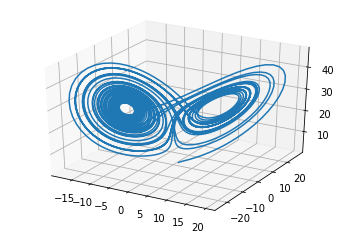

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

### Equations

In [ ]:
class Lorenz:
    def __init__(self, sigma, rho, beta, x0, y0, z0):
        self.s = sigma
        self.r = rho
        self.b = beta
        self.state = (x0, y0, z0)
        
    def update_state(self):
        x, y, z = self.state
        self.state = (self.s * (y - x), x * (self.r - z) - y, x * y - self.b * z)

### Numerical Methods

In [ ]:
def rk4(f, y0, t0, tN, N):
    '''
    Returns list of function values approximated with the Runge-Kutta method of 4th order.

    f .... function of ODE y' = f(y, t)
    y0 ... initial value y(t0) = y0
    t0 ... start of interval
    tN ... end of interval
    N .... number of steps
    '''
    
    h = (tN - t0) / N
    t = t0 + h * np.arange(N+1)
    
    y = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, np.size(y0)))
    y[0] = y0
    
    for n in range(N):
        k1 = f(y[n], t[n])
        k2 = f(y[n] + h/2 * k1, t[n] + h/2)
        k3 = f(y[n] + h/2 * k2, t[n] + h/2)
        k4 = f(y[n] + h * k3, t[n] + h)
        y[n+1] = y[n] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    return t, y

In [ ]:
def adams_bashforth(f, y0, t0, tN, N, order=4, inits=None):
    '''
    Returns list of function values approximated with the Adams-Bashforth method.

    f ....... function of ODE y' = f(y, t)
    inits ... initial values (y0, ...)
    t0 ...... start of interval
    tN ...... end of interval
    N ....... number of steps
    order ... order of method
    inits ... inital values after y0 up to order
    '''
    
    h = (tN - t0) / N
    t = t0 + h * np.arange(N+1)
    
    koeffs = (1,
              [-1/2, 3/2],
              [5/12, -16/12, 23/12],
              [-9/24, 37/24, -59/24, 55/24],
              [251/720, -1274/720, 2616/720, -2774/720, 1901/720])
    
    y = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    y[0] = y0
    
    fn = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    fn[0] = f(y0, t0)
    
    s = order-1 if 1 <= order <= 4 else 3
    
    if s > 0:
        if inits is None or len(inits) != s:
            inits = rk4(f, y0, t0, t0+h*s, s)[1][1:]
        for i in range(s):
            y[i+1] = inits[i]
            fn[i+1] = f(y[i+1], t[i+1])
        
    for n in range(N-s):
        y[n+s+1] = y[n+s] + h * np.dot(koeffs[s], fn[n:n+s+1])
        fn[n+s+1] = f(y[n+s+1], t[n+s+1])
    
    return t, y

In [ ]:
def ABE(f, y0, t0, tN, N, order=4, inits=None):
    '''
    Returns list of function values approximated with the predictor-corrector method using Adams-Moulton and Adams-Bashforth.

    f ....... function of ODE y' = f(y, t)
    y0 ...... initial value y(t0) = y0
    t0 ...... start of interval
    tN ...... end of interval
    N ....... number of steps
    order ... order of method
    inits ... optional initial values after y0 up to order
    '''
    
    h = (tN - t0) / N
    t = t0 + h * np.arange(N+1)
    
    koeffs = ([1/2, 1/2],
              [-1/12, 2/3, 5/12],
              [1/24, -5/24, 19/24, 9/24],
              [-19/720, 106/720, -264/720, 646/720, 251/720])
    
    y = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    y[0] = y0
        
    fn = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    fn[0] = f(y0, t0)
        
    s = order-1 if 1 <= order <= 4 else 3
    
    if s > 0:
        if inits is None or len(inits) != s:
            inits = rk4(f, y0, t0, t0+h*s, s)[1][1:]
        for i in range(s):
            y[i+1] = inits[i]
            fn[i+1] = f(y[i+1], t[i+1])
    
    yp = y
    fp = fn
    
    for n in range(N-s):
        # predictor: adams bashforth
        yp[n+s+1] = adams_bashforth(f, y[n], t[n], t[n+s+1], s+1, order=s+1, inits=y[n+1:n+s+1])[1][-1]
        
        # evaluation
        fp[n+s+1] = f(yp[n+s+1], t[n+s+1])
        
        # corrector: adams moulton
        y[n+s+1] = y[n+s] + h * np.dot(koeffs[s][0:-1], fn[n:n+s+1]) + h * koeffs[s][-1] * fp[n+s+1]
        
        #evaluation
        fn[n+s+1] = f(y[n+s+1], t[n+s+1])
        
    return t, y